In [16]:
import numpy as np
import scipy.stats as sp
import pandas as pd
from sklearn.preprocessing import minmax_scale, scale, MinMaxScaler

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, brier_score_loss

In [18]:
from wgan.simulation import create_continuous_data
from wgan.imblearn import GANbalancer
import wgan.data_loader

In [19]:
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC
from types import MethodType

In [20]:
from sklearn.utils import safe_indexing

def create_samples(self, X, y):
        # FIXME: uncomment in version 0.6
        # self._validate_estimator()

        for class_sample, n_samples in self.sampling_strategy_.items():
            if n_samples == 0:
                continue
            target_class_indices = np.flatnonzero(y == class_sample)
            X_class = safe_indexing(X, target_class_indices)

            self.nn_k_.fit(X_class)
            nns = self.nn_k_.kneighbors(X_class, return_distance=False)[:, 1:]
            X_new, y_new = self._make_samples(X_class, y.dtype, class_sample,
                                              X_class, nns, n_samples, 1.0)

        return X_new, y_new


SMOTE._sample_only = create_samples

## Artifical Data Generation

In [21]:
N_SAMPLES = 10000
N_VAR = 6
data = {
    "Independent" : create_continuous_data(n_samples=N_SAMPLES, n_var=N_VAR, n_dependent=0, pos_ratio=0.5),
    "Dependent" : create_continuous_data(n_samples=N_SAMPLES, n_var=N_VAR, n_dependent=5, pos_ratio=0.5),
    "Mixed" : create_continuous_data(n_samples=N_SAMPLES, n_var=N_VAR, n_dependent=N_VAR//2, pos_ratio=0.5)
}
    

In [22]:
gan_balancer = GANbalancer(idx_cont=range(N_VAR), categorical=None, auxiliary=False,
                           generator_input=N_VAR*1, generator_layers=[N_VAR*2], 
                           critic_layers=[N_VAR*2], critic_iterations=3,
                           learning_rate = [1e-6, 1e-6],
                           batch_size = 128, n_iter=0, 
                           sampling_strategy = {0:N_SAMPLES, 1:0}, verbose=0)

In [23]:
gan_balancer._fit(data["Independent"][0], y=np.zeros(shape=N_SAMPLES))

GANbalancer(auxiliary=False, batch_size=128, categorical=None,
      critic_iterations=3, critic_layers=[12], generator_input=6,
      generator_layers=[12], idx_cont=range(0, 6),
      learning_rate=[1e-06, 1e-06], n_iter=0, random_state=None,
      sampling_strategy={0: 10000, 1: 0}, verbose=0)

In [24]:
smote = SMOTE(sampling_strategy = {0:N_SAMPLES, 1:0})
smote._validate_estimator()
smote.sampling_strategy_ = {0:N_SAMPLES, 1:0}

In [25]:
def check_first_moments(X):
    return np.vstack([x.mean(axis=0) for x in X])

def check_second_moments(X):
    return [np.cov(x, rowvar=False).round(2) for x in X]

## Classifier performance on synthetic data

Train the generator to create minority cases for 1000 iterations. Train the classifier on real majority cases and fake minority cases. Evaluate the classifier on real test data. 

In [26]:
max_iter = 10000
auc_over_iter = np.empty([max_iter])

X = data["Dependent"][0]
y = data["Dependent"][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5, stratify=y)

In [27]:
for i in range(max_iter):
    logit = LogisticRegression(C=100, solver="lbfgs")

    gan_balancer._update(X_train[y_train==1,:], y=np.zeros(shape=N_SAMPLES//4), n_iter=100)

    logit.fit(X = np.vstack([gan_balancer.generator.sample_data(N_SAMPLES//4), X_train[y_train==0,:]]),
              y = np.hstack([np.ones(N_SAMPLES//4), y_train[y_train==0] ])
                            )
    
    auc_over_iter[i] = roc_auc_score(y_true = y_test, y_score = logit.predict(X_test))

Text(0, 0.5, 'AUC')

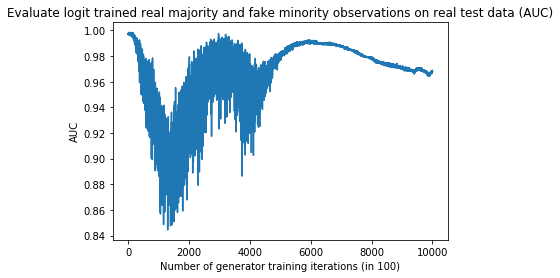

In [28]:
import matplotlib.pyplot as plt 
plt.plot(auc_over_iter)
plt.title("Evaluate logit trained real majority and fake minority observations on real test data (AUC)")
plt.xlabel("Number of generator training iterations (in 100)")
plt.ylabel("AUC")